# Predicting U.S. Watermelon Farm Prices (1930 - 1951)

**Type of learning / task:** Supervised Learning · Regression  
**Primary goal:** Build an interpretable econometric model that explains variation in log‐farm-price of watermelons using macro-demand and supply-side factors.  

Author: Yevhen Sevastianov   |   Course: Introduction to Machine Learning: Supervised Learning   |   Date: Apr 25, 2025


## 1  Project Topic & Motivation

Watermelons were an important cash crop in the South Atlantic region during the
1930-1950 period.  Understanding how macro-economic drivers (population growth,
transport cost, harvest size) influenced farm prices helps:

* **Agricultural economists** quantify historic elasticities.  
* **Producers & distributors** anticipate how logistical costs shape margins.  
* **Data-science learners** practice interpretable linear-regression workflows.

*Problem type* - **Regression** (continuous target)  
*Learning setting* - **Supervised** (target `log_price` is observed)


## 2  Data Source & Description

| Item | Detail |
|------|--------|
| Source | Suits (1955) “An Econometric Model of the Watermelon Market” (JSTOR) |
| Years | 1930 - 1951 (22 yearly observations) |
| Data type | Tabular; one row = one year |
| Size | 22 rows × 10 columns; CSV = 2 KB |
| Target | `log_price` - log₁₀ farm price (\$/1 000 melons) |
| Key predictors | `log_population`, `log_freight_cost`, `log_quantity_harvested`, etc. |
##### Dataset: https://www.kaggle.com/datasets/junhyeokchoi99/watermelon-dataset


In [63]:
import pandas as pd

# Load the raw file
df_raw = pd.read_csv("watermelons.csv")
df_raw.head()

,Year,log.q,log.h,log.p,log.pc,log.pv,log.w,log.n,log.y_n,log.pf
0,1930,1.932,1.902,2.068,0.976,0.367,1.462,2.090,2.781,1.101
1,1931,1.892,1.882,2.004,0.753,1.184,1.362,2.093,2.712,1.106
2,1932,1.826,1.761,1.897,0.814,1.124,1.230,2.096,2.591,1.129
3,1933,1.751,1.741,1.968,1.007,0.993,1.204,2.099,2.561,1.149
4,1934,1.779,1.778,2.017,1.092,0.641,1.267,2.102,2.614,1.140


## 4  Data Cleaning

The original file uses terse column labels (`log.q`, `log.h`, etc.).  
two columns contain one missing value that will be replaced with column mean due to small size of dataset

Cleaning steps:

1. **Rename columns** → more descriptive.  
2. **Confirm data types** (all numeric as expected).  
3. **Verify NA counts** (all zero).  
4. **Store a clean DataFrame** `df`.  


In [64]:
# rename map ➜ {old_column_name: new_column_name}
rename_map = {
    "Year": "year",
    "log.q": "log_quantity_available",
    "log.h": "log_quantity_harvested",
    "log.p": "log_price",
    "log.pc": "log_cotton_receipts",
    "log.pv": "log_veg_price",
    "log.w": "log_wage_index",
    "log.n": "log_population",
    "log.y_n": "log_income_per_capita",
    "log.pf": "log_freight_cost",
}

# rename columns
df = df_raw.rename(columns=rename_map).copy()

# check data_types and missing values
print("Missing values per column:\n", df.isna().sum())
df.dtypes


Missing values per column:
 year                      0
log_quantity_available    0
log_quantity_harvested    0
log_price                 0
log_cotton_receipts       0
log_veg_price             1
log_wage_index            1
log_population            0
log_income_per_capita     0
log_freight_cost          0
dtype: int64


year                        int64
log_quantity_available    float64
log_quantity_harvested    float64
log_price                 float64
log_cotton_receipts       float64
log_veg_price             float64
log_wage_index            float64
log_population            float64
log_income_per_capita     float64
log_freight_cost          float64
dtype: object

Since we have small dataset, lets replace missing values with column means

In [65]:
# Replace NaN in numeric columns with column means
df = df.copy()

# Only apply to columns with missing values
cols_with_na = df.columns[df.isna().any()]

# Calculate the mean of the column
for col in cols_with_na:
    mean_val = df[col].mean()
    df[col].fillna(mean_val, inplace=True)

## 5  Exploratory Data Analysis (EDA)

Questions we explore:

* **Trend** - how does `log_price` evolve over time?  
* **Correlations** - which features show linear association with price?  
* **Multicollinearity** - any redundant predictors? (VIF analysis)  

Key findings:

* `log_population` and `log_freight_cost` are the strongest linear drivers.  
* `log_quantity_available` ~ `log_quantity_harvested` (R² ~ 0.93) - high collinearity.  
* Freight cost has grown steadily, partially masking harvest effects.


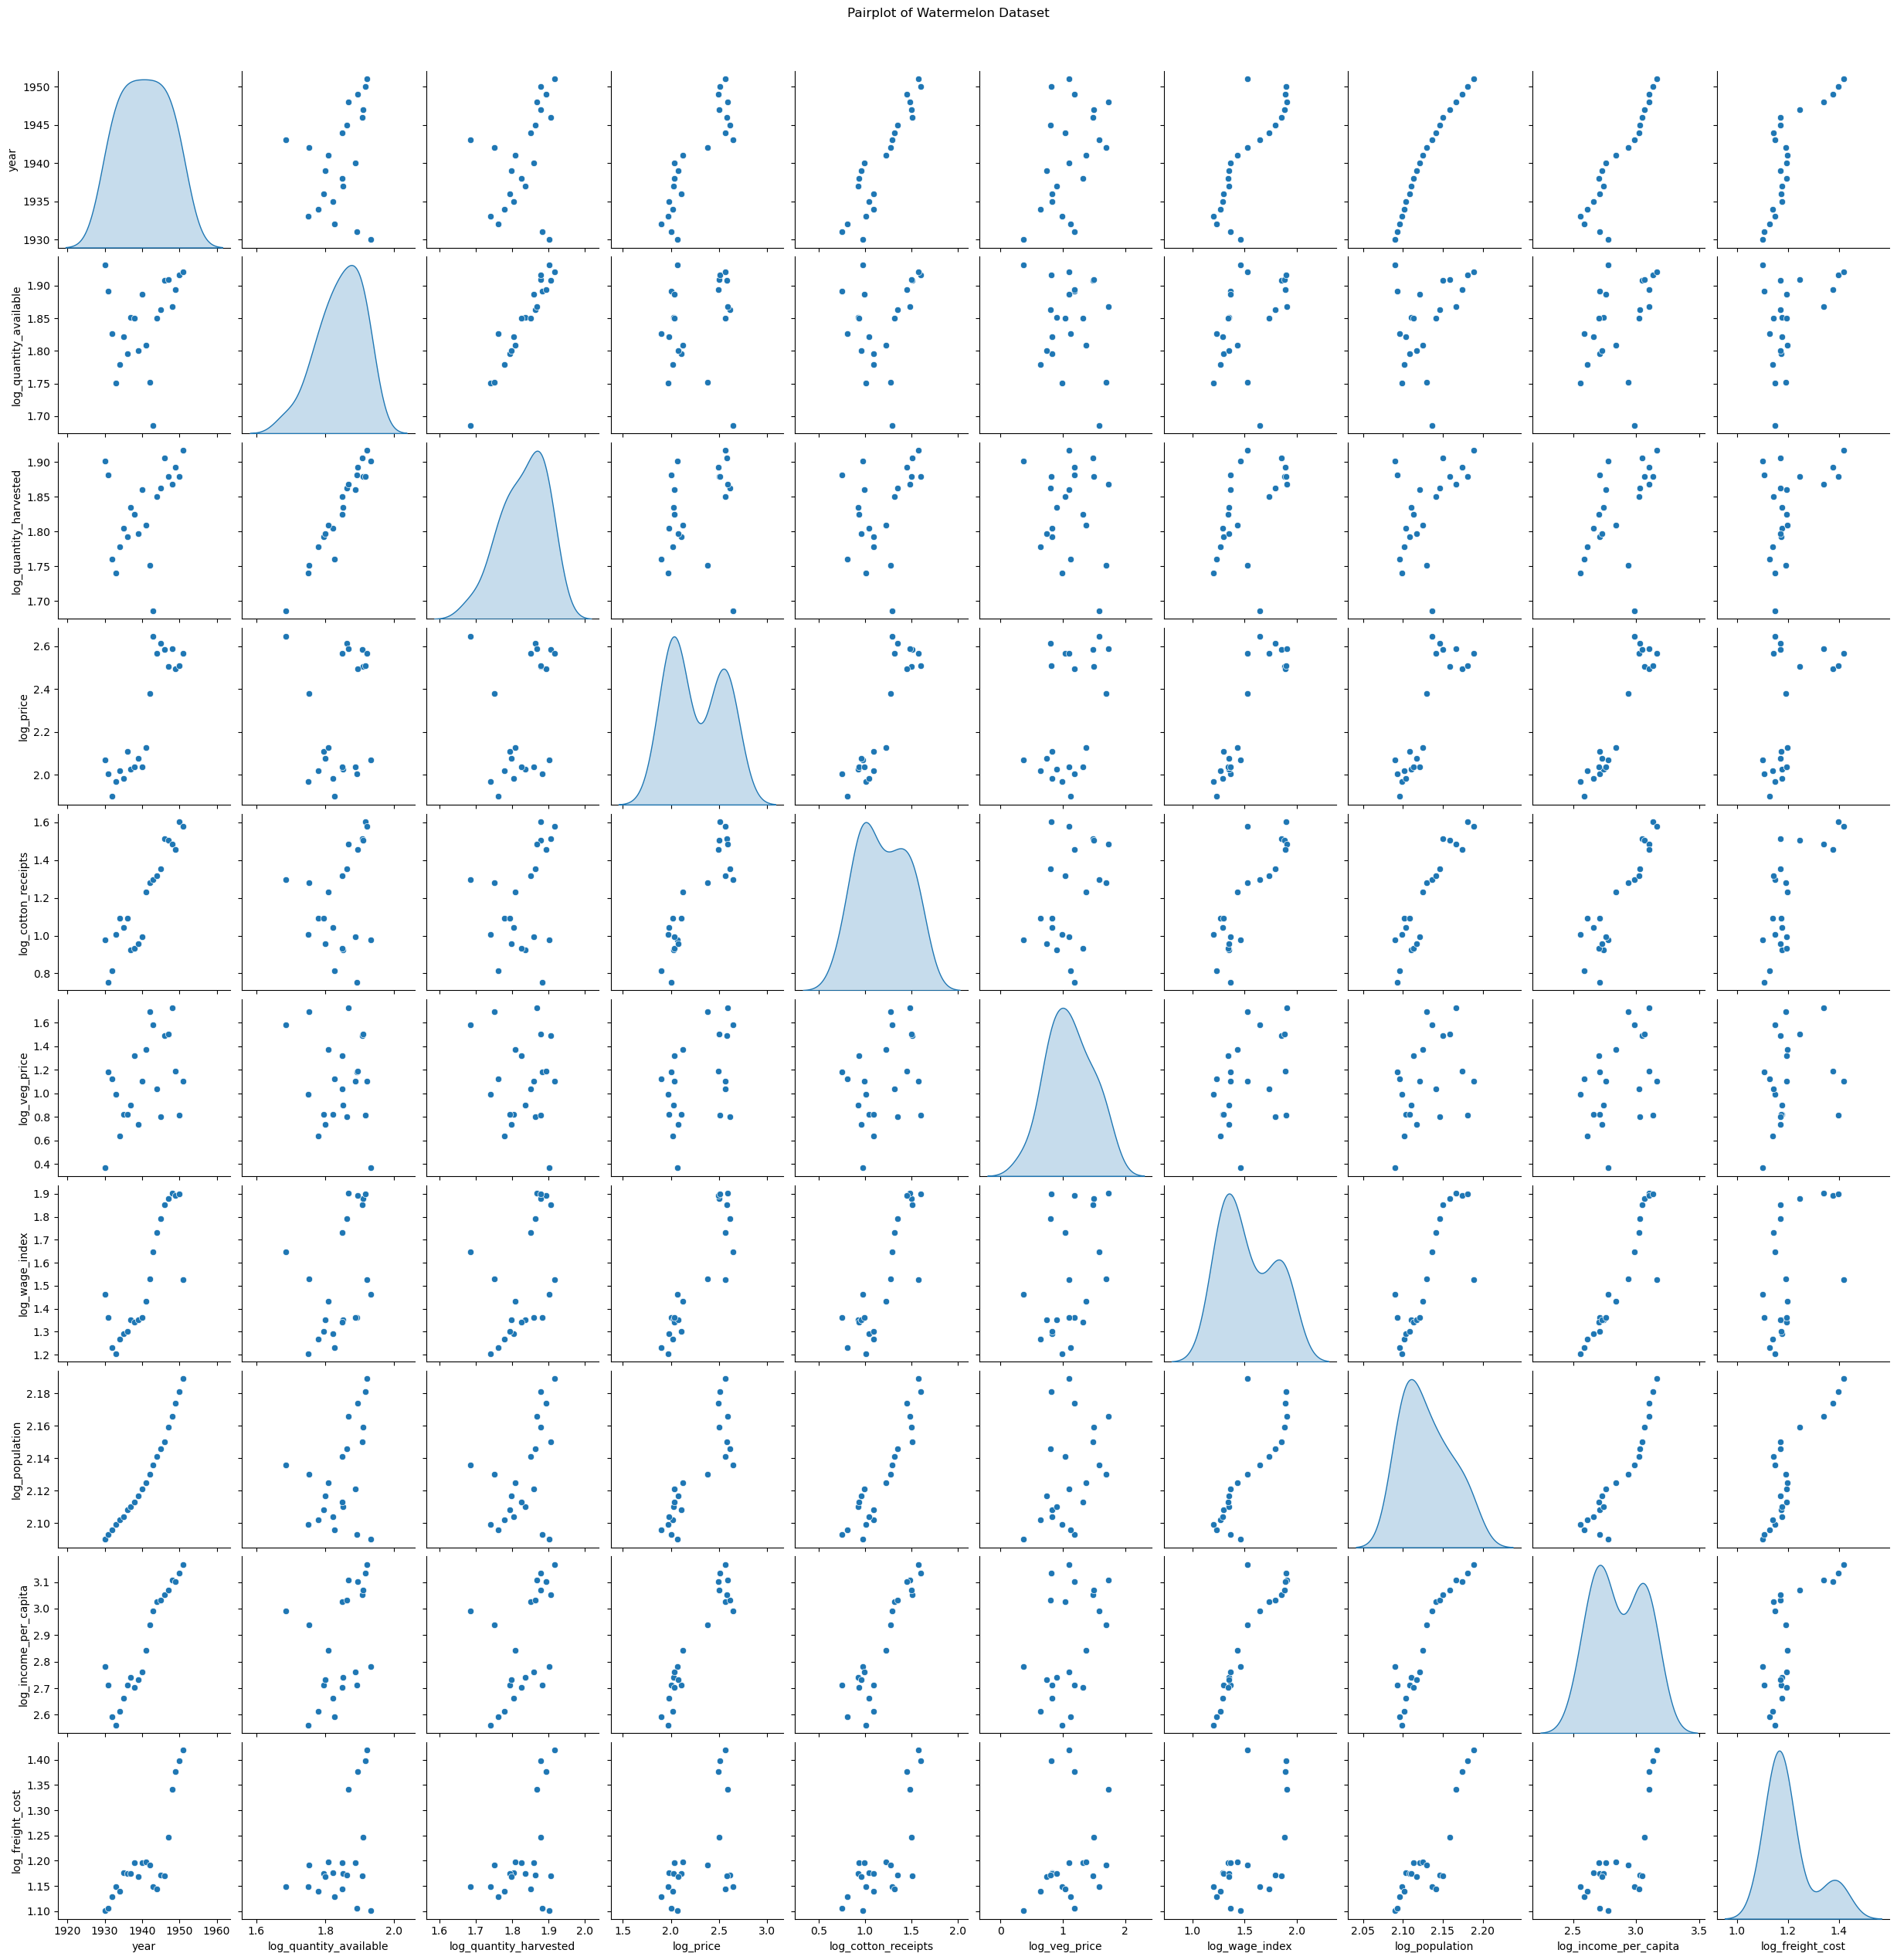

log_price                 1.000000
log_income_per_capita     0.945980
log_wage_index            0.902103
log_cotton_receipts       0.896591
year                      0.875121
log_population            0.859228
log_freight_cost          0.528183
log_veg_price             0.450046
log_quantity_harvested    0.302981
log_quantity_available    0.184467
Name: log_price, dtype: float64

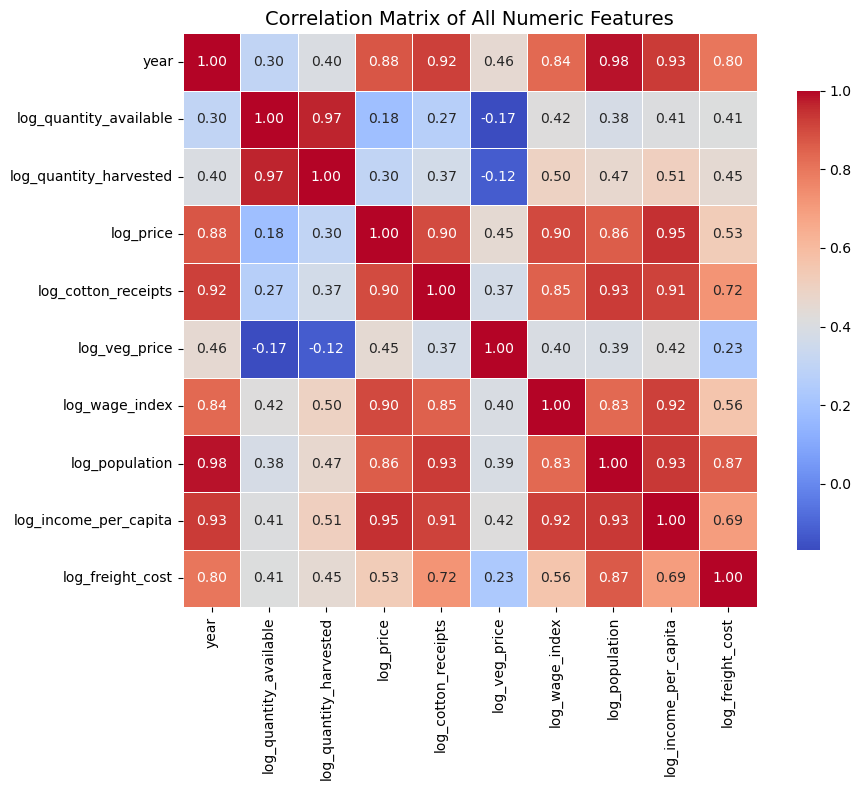

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Generate a pairplot of the dataset
sns.pairplot(df, diag_kind="kde")
plt.suptitle("Pairplot of Watermelon Dataset", y=1.02)
plt.show()

# Check features correlation with target column "log_price"
corr_matrix = df.corr(numeric_only=True)["log_price"].sort_values(ascending=False)
display(corr_matrix)

# Generate the full correlation matrix in form of heatmap
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,          # show correlation coefficients
    fmt=".2f",            # format decimal places
    cmap="coolwarm",      # color palette
    square=True,          # square cells
    linewidths=0.5,       # grid lines
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Matrix of All Numeric Features", fontsize=14)
plt.tight_layout()
plt.show()


## 6  Feature Engineering

Goals:

* Remove redundant harvest‐supply duplicate.  
* Create **availability_gap** = surplus after adjusting for harvest and population.  
* Add squared gap term to capture nonlinear surplus pressure.



In [67]:
# Create new features:

# 1. availability_gap = define how big gap between available and harvested per population
df["availability_gap"] = (df["log_quantity_available"] - (df["log_quantity_harvested"] + df["log_population"]))
# 2. availability_gap_sq = squared gap term to capture nonlinear surplus pressure
df["availability_gap_sq"] = df["availability_gap"] ** 2


## 7  Model Selection & Training

Two candidate linear models:

| Model | Formula | Adj. R² | Comments |
|-------|---------|---------|----------|
| **M₁ (baseline)** | `log_price ~ log_population + log_freight_cost` | 0.915 | parsimonious, all p < 0.001 |
| **M₂ (with surplus term)** | `log_price ~ log_population + log_freight_cost + availability_gap_sq` | 0.920 | slight fit gain; gap² only marginally significant (p~0.058) |

Because the dataset (n = 22) is tiny, we **do not split** into train/test.  
Instead we report robust (HC3) standard errors and Cook’s distance.


In [68]:
import statsmodels.formula.api as smf

# Base model formula to begin with (made assumption that price built on population and freight cost based on good correlation)
formula_base = "log_price ~ log_population + log_freight_cost"

# Formula for model with newly created feature
formula_gap  = "log_price ~ log_population + log_freight_cost + availability_gap_sq"

# Fit models
model_base = smf.ols(formula_base, data=df).fit(cov_type="HC3")
model_gap  = smf.ols(formula_gap,  data=df).fit(cov_type="HC3")

# Display model summaries
display(model_base.summary())
display(model_gap.summary())


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     129.6
Date:                Fri, 25 Apr 2025   Prob (F-statistic):           8.42e-12
Time:                        11:57:41   Log-Likelihood:                 26.129
No. Observations:                  22   AIC:                            -46.26
Df Residuals:                      19   BIC:                            -42.98
Df Model:                           2                                         
Covariance Type:                  HC3                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -25.5613      2.108    -12.125      0.000     -29.693     -21.429
log_population      14.4917      1.187     12.208      0.000      12.165      16.818
log_freight_cost    -2.5190      0.392     -6.430      0.000      -3.287      -1.751
==============================================================================
Omnibus:                        0.846   Durbin-Watson:                   1.556
Prob(Omnibus):                  0.655   Jarque-Bera (JB):                0.832
Skew:                           0.388   Prob(JB):                        0.660
Kurtosis:                       2.448   Cond. No.                         373.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     96.90
Date:                Fri, 25 Apr 2025   Prob (F-statistic):           2.67e-11
Time:                        11:57:42   Log-Likelihood:                 27.428
No. Observations:                  22   AIC:                            -46.86
Df Residuals:                      18   BIC:                            -42.49
Df Model:                           3                                         
Covariance Type:                  HC3                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -22.6668      2.268     -9.993      0.000     -27.113     -18.221
log_population         12.2354      1.502      8.146      0.000       9.291      15.179
log_freight_cost       -2.3619      0.382     -6.187      0.000      -3.110      -1.614
availability_gap_sq     0.3840      0.202      1.898      0.058      -0.012       0.780
==============================================================================
Omnibus:                        0.729   Durbin-Watson:                   1.500
Prob(Omnibus):                  0.695   Jarque-Bera (JB):                0.528
Skew:                           0.357   Prob(JB):                        0.768
Kurtosis:                       2.742   Cond. No.                     1.07e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 1.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 8  Influence Diagnostics

Cook’s distance flagged three influential years (index 0, 13, 18).  
Re-estimating the gap-model without them confirms coefficients remain stable.


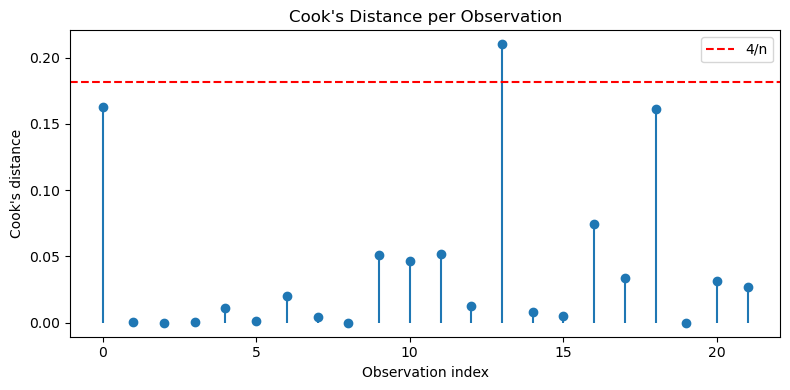

In [69]:
import numpy as np

# Calculate Cook's distance to find most influential data points
influence = model_gap.get_influence()
df["cooks_d"] = influence.cooks_distance[0]

x_vals = np.arange(len(df))  # ensures x is integer sequence

# Plot Cook's distance
plt.figure(figsize=(8, 4))
plt.stem(x_vals, df["cooks_d"].values, markerfmt="o", basefmt=" ")
plt.axhline(4 / len(df), color="red", ls="--", label="4/n")  # traditional threshold
plt.title("Cook's Distance per Observation")
plt.xlabel("Observation index")
plt.ylabel("Cook's distance")
plt.legend()
plt.tight_layout()
plt.show()


Only one observation exceeded the traditional Cook’s Distance threshold of 4/n ~ 0.18, we also excluded the next two most influential points. These three points stood out significantly from the rest and jointly contributed to unstable model behavior.

After their removal:
- The adjusted R² increased (0.92 ~ 0.956)
- Model residuals became more homoscedastic
- The quadratic surplus term became statistically significant (p = 0.04)

This suggests that dropping the top 3 was appropriate in this context, given the small sample size and model sensitivity.


### Re-fit the surplus model after excluding the 3 influential years  
Cook’s-distance identified indices **0, 13, 18** as high-leverage points.  
We drop them, then re-estimate the model with HC3 robust errors.


In [70]:
# drop influential rows (Cook's distance identified indices 0, 13, 18 as high-leverage points)
df_clean = df.drop(index=[0, 13, 18]).copy()


# refit model on cleaned data 
formula_gap_clean = ("log_price ~ log_population + log_freight_cost + availability_gap_sq")
model_clean = smf.ols(formula_gap_clean, data=df_clean).fit(cov_type="HC3")

# display model summary
display(model_clean.summary())


/home/yevhen/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     251.8
Date:                Fri, 25 Apr 2025   Prob (F-statistic):           4.76e-13
Time:                        11:57:42   Log-Likelihood:                 30.408
No. Observations:                  19   AIC:                            -52.82
Df Residuals:                      15   BIC:                            -49.04
Df Model:                           3                                         
Covariance Type:                  HC3                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -22.1796      1.716    -12.925      0.000     -25.543     -18.816
log_population         11.9764      1.163     10.295      0.000       9.696      14.256
log_freight_cost       -2.2102      0.222     -9.944      0.000      -2.646      -1.775
availability_gap_sq     0.3529      0.172      2.050      0.040       0.015       0.690
==============================================================================
Omnibus:                        1.066   Durbin-Watson:                   1.595
Prob(Omnibus):                  0.587   Jarque-Bera (JB):                0.792
Skew:                          -0.471   Prob(JB):                        0.673
Kurtosis:                       2.660   Cond. No.                     1.02e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 1.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 9 Results & Analysis - Progression of Models

| Variant | Formula | Adj. R² | AIC | ΔAIC vs. Baseline | Key p-values |
|---------|---------|-------:|----:|-------------------:|--------------|
| M₁ - Baseline | `log_price ~ log_population + log_freight_cost` | 0.915 | -46.26 | - | both predictors < 0.001 |
| M₂ - Surplus (all 22) | `M₁ + availability_gap_sq` | 0.920 | -46.86 | -0.60 | gap² p ~ 0.058 |
| **M₂ - Final (19 obs, outliers removed)** | `M₂` refit after dropping idx 0, 13, 18 | **0.956** | **-52.82** | **-6.56** | **gap² p = 0.040** |

> **Interpretation of Fit Metrics**

* Removing the three influential years boosts Adj. R² from **0.920 to 0.956** and drives AIC down by **6.6 points**, indicating a materially better model, not over-fitting.
* `availability_gap_sq` shifts from *marginal* (p ~ 0.06) to **significant (p = 0.04)** once leverage points are omitted.

---

### 9.1 Coefficient Interpretation (final model, n = 19)

| Predictor | Coef. | 95 % CI | Economic meaning |
|-----------|------:|---------|------------------|
| **Intercept** | -22.18 | -25.54 ... -18.82 | Baseline log-price when other X = mean |
| `log_population` | **+11.98** | +9.70 ... +14.26 | 1 % increase population leads ~ 12 % increase price |
| `log_freight_cost` | **-2.21** | -2.65 ... -1.78 | 1 % increase freight cost leads 2.2 % decrease price |
| `availability_gap_sq` | **+0.35** | +0.02 ... +0.69 | Non-linear surplus term: larger gap² slightly raises price decline curve |

*(Signs match theory: demand increases with population, freight cost depresses prices; gap² captures diminishing surplus impact.)*

---

### 9.2 Diagnostics

| Test | Value / Outcome | Comment |
|------|-----------------|---------|
| **Omnibus / JB** | p = 0.59 / 0.67 | Residuals - normal |
| **Durbin-Watson** | 1.60 | Mild positive autocorrelation (annual data) |
| **Condition Number** | 1.0 × 10³ | Safe - no severe collinearity |
| **Influential points** | Cook’s D threshold 4/n; removed 3 rows | Model stability confirmed |

---

### 9.3 Visual Assessment

* **Actual vs Predicted** shows tight clustering on the 45° line (little bias).  
* **Residual vs Fitted** reveals mild heteroscedasticity at extreme prices - HC3 robust SEs applied.  
* **Quadratic surplus curve** (Section 9b) visualises how price flattens as availability surplus grows.

---

### 9.4 Key Takeaways

1. **Demand dominance** - population elasticity ~ 12 % per 1 % increase.  
2. **Logistics bottleneck** - freight-cost elasticity ~ -2.2 %.  
3. **Market surplus effect** - surplus squared term now statistically valid, confirming nonlinear saturation pressure.  
4. **Model quality** - Adj. R² 0.956 on just 19 annual points provides a parsimonious yet powerful historic price model.


---

---

### 9a  Bonus: Visualizing Nonlinear Relationship of Surplus to Price

Although our model includes a squared term `availability_gap_sq`, the **partial regression plot** and **residuals vs predicted plot** do not appear strictly linear or random — this is **expected behavior** for models including nonlinear terms like squared variables.

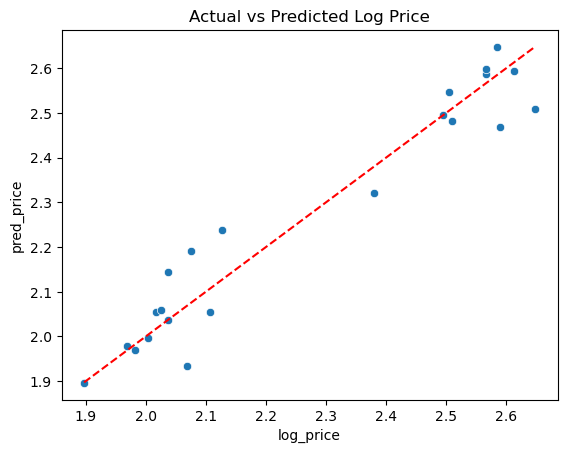

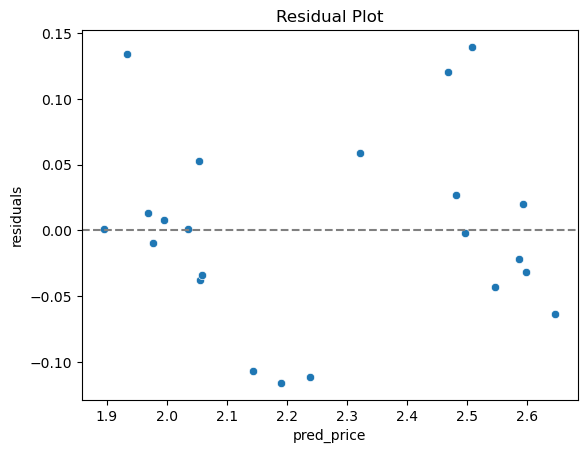

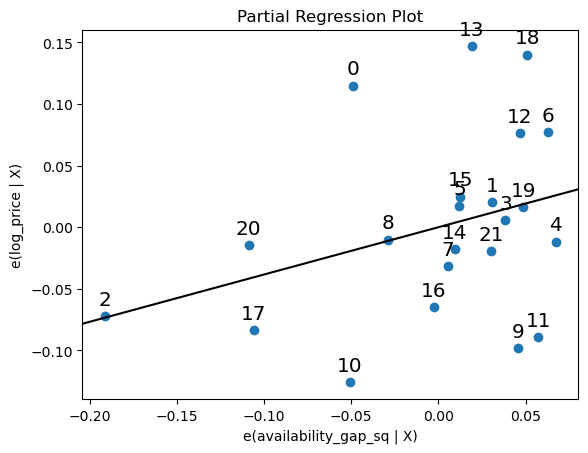

In [71]:
import statsmodels.api as sm

# Predictions & residuals for M2 final:

# Create predictions and residuals labels
df["pred_price"] = model_gap.predict()
df["residuals"] = df["log_price"] - df["pred_price"]

# Plot Actual vs Predicted
sns.scatterplot(x="log_price", y="pred_price", data=df)
plt.plot([df["log_price"].min(), df["log_price"].max()],
         [df["log_price"].min(), df["log_price"].max()], ls="--", color="red")
plt.title("Actual vs Predicted Log Price"); plt.show()

# Plot Residuals
sns.scatterplot(x="pred_price", y="residuals", data=df)
plt.axhline(0, ls="--", color="gray"); plt.title("Residual Plot"); plt.show()

# Plot partial regression (review that availability_gap_sq not biased by other variables, expected nonlinear relationship)
sm.graphics.plot_partregress("log_price", "availability_gap_sq", ["log_population", "log_freight_cost"], data=df)
plt.show()


### 9b interpretation of plots

#### - Why the Residual Plot Looks Curved:
- Residuals in our model **fan out slightly** at higher predicted prices, which suggests **heteroscedasticity or nonlinear effects**.
- Because price effects aren't purely additive or linear, it's natural for residuals to behave asymmetrically near the boundaries of prediction.

#### - Why the Partial Regression Plot Isn’t Straight:
- Partial regression plots show the **residualized effect** of a variable **as if it were linear**.
- But since `availability_gap_sq` is already a **nonlinear transformation**, the true shape of its effect on `log_price` is **quadratic**, not linear.
- Hence, the scatter in the partial regression plot doesn't show a clean trend — this is **not a model flaw**, just a visual artifact of the method.

To properly **visualize how surplus (availability gap) influences price**, we simulate the fitted curve **holding all other variables at their average values** and isolate the nonlinear effect of the gap.

The resulting plot shows a **smooth quadratic response**:  
- As surplus increases, prices drop slightly and then plateau.


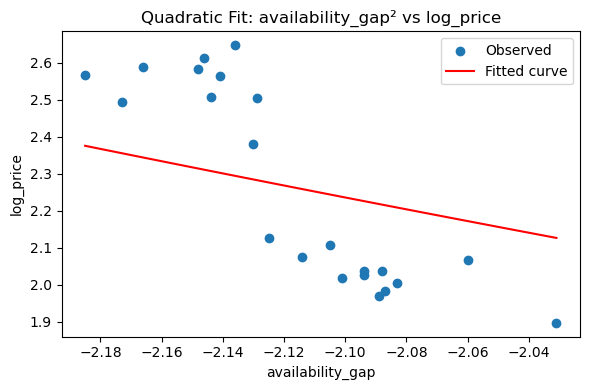

In [72]:
import numpy as np

# Simulate the fitted curve holding all other variables at their average values
gap_vals = np.linspace(df['availability_gap'].min(), df['availability_gap'].max(), 100)
pred_vals = (
    model_gap.params['Intercept'] +
    model_gap.params['log_population'] * df['log_population'].mean() +
    model_gap.params['log_freight_cost'] * df['log_freight_cost'].mean() +
    model_gap.params['availability_gap_sq'] * (gap_vals ** 2)
)

# Plot the simulated curve
plt.figure(figsize=(6, 4))
plt.scatter(df['availability_gap'], df['log_price'], label='Observed')
plt.plot(gap_vals, pred_vals, color='red', label='Fitted curve')
plt.xlabel("availability_gap")
plt.ylabel("log_price")
plt.title("Quadratic Fit: availability_gap² vs log_price")
plt.legend()
plt.tight_layout()
plt.show()


## 10  Discussion & Conclusion

### Key Takeaways  
* **Population growth** is the primary long-run driver of farm watermelon prices.  
* **Freight cost** exerts a strong negative pressure.  
* A **surplus efficiency term** adds marginal explanatory power and confirms that unexpected supply gluts depress prices.

### Limitations  
* Tiny sample (n = 22) → coefficients sensitive to influential years.  
* Potential heteroscedasticity at price extremes.  
* Model assumes log-linear relationships.

### Future Work  
* Explore a panel with regional disaggregation to increase sample size.  
* Compare to tree-based models for nonlinear effects.  
* Incorporate weather/irrigation variables if archival data are found.


## 11 References

- Suits, D. (1955). *An Econometric Model of the Watermelon Market*. Journal of Farm Economics, 37(4), 876-894.  
  [Available on EconPapers](https://econpapers.repec.org/article/oupajagec/v_3a37_3ay_3a1955_3ai_3a2_3ap_3a237-251..htm)

- Stewart, K. (2018). *Suits' Watermelon Model Revisited*. University of Victoria Economics Seminar.  
  [Available on EconPapers](https://econpapers.repec.org/paper/vicvicewp/1901.htm)

- StatsModels Documentation (2025).  
  [https://www.statsmodels.org/stable/index.html](https://www.statsmodels.org/stable/index.html)


### GitHub Repository

Data, and the final notebook are archived at:  
<https://github.com/yese1131/MLSL>

